In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electric-production/Electric_Production.csv


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
series=pd.read_csv("../input/electric-production/Electric_Production.csv",index_col="DATE",parse_dates=True)
series.head()

,Value
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [4]:
series.rename(columns={"Value":"Consumption"},inplace=True)

In [5]:
series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Consumption  397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


In [6]:
series.describe()

,Consumption
count,397.000000
mean,88.847218
std,15.387834
min,55.315100
25%,77.105200
50%,89.779500
75%,100.524400
max,129.404800


In [7]:
series.isnull().sum()

Consumption    0
dtype: int64

In [8]:
series["Month"]=series.index.month
series["Year"]=series.index.year
series["Day_of_week"]=series.index.dayofweek

In [9]:
series.head()

,Consumption,Month,Year,Day_of_week
DATE,,,,
1985-01-01,72.5052,1,1985,1
1985-02-01,70.6720,2,1985,4
1985-03-01,62.4502,3,1985,4
1985-04-01,57.4714,4,1985,0
1985-05-01,55.3151,5,1985,2


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [11]:
plt.rcParams.update({"figure.figsize":(12,8)})

<AxesSubplot:title={'center':'Consumption Time Series'}, xlabel='DATE', ylabel='Consumption'>

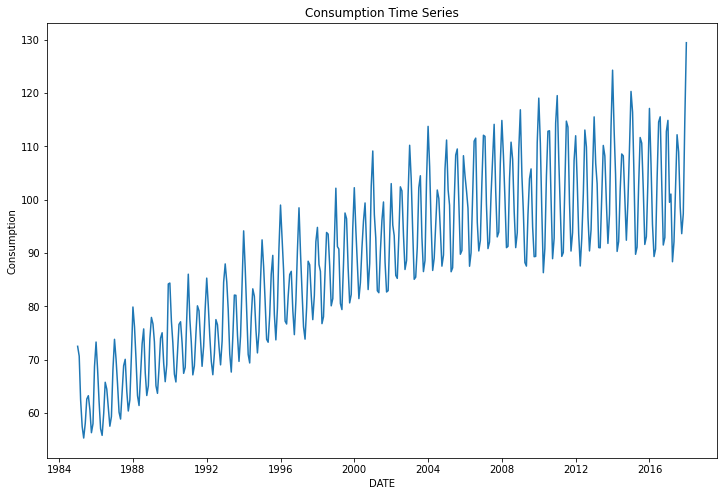

In [12]:
plt.title("Consumption Time Series")
sns.lineplot(y=series["Consumption"],x=series.index)


<AxesSubplot:xlabel='Month', ylabel='Consumption'>

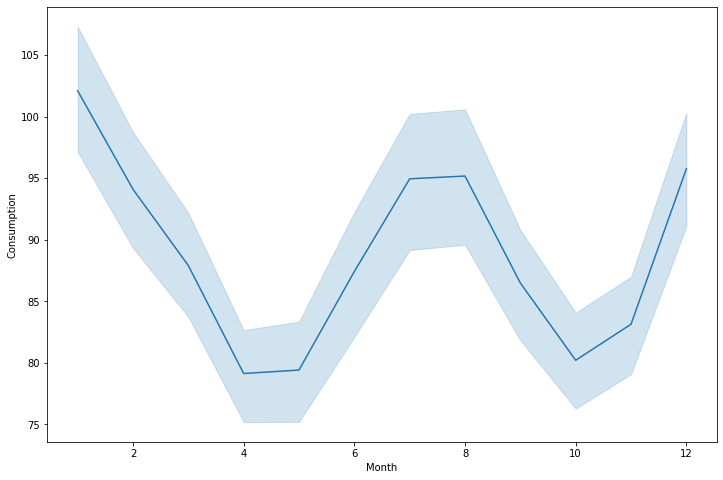

In [13]:
sns.lineplot(x="Month",y="Consumption",data=series)

<AxesSubplot:xlabel='Month', ylabel='Consumption'>

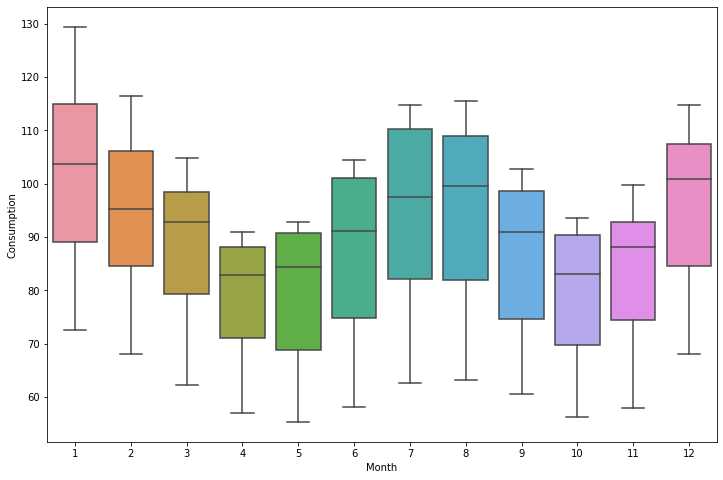

In [14]:
sns.boxplot(x="Month",y="Consumption",data=series)

**There is strong monthly seasonality**

<AxesSubplot:xlabel='Year', ylabel='Consumption'>

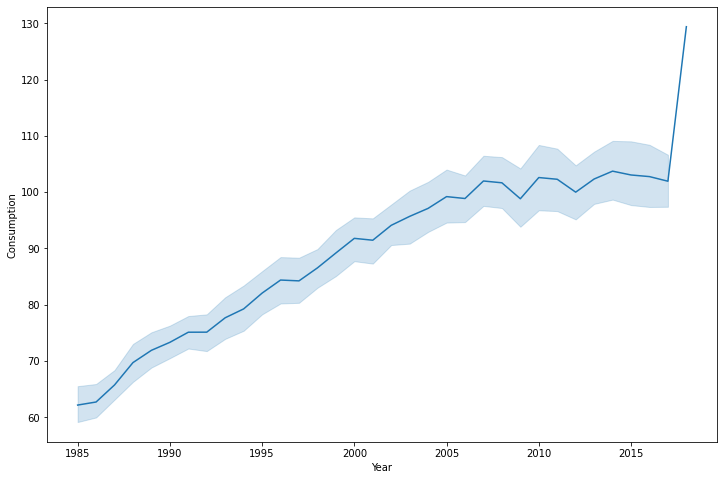

In [15]:
sns.lineplot(x="Year",y="Consumption",data=series)

<AxesSubplot:xlabel='Year', ylabel='Consumption'>

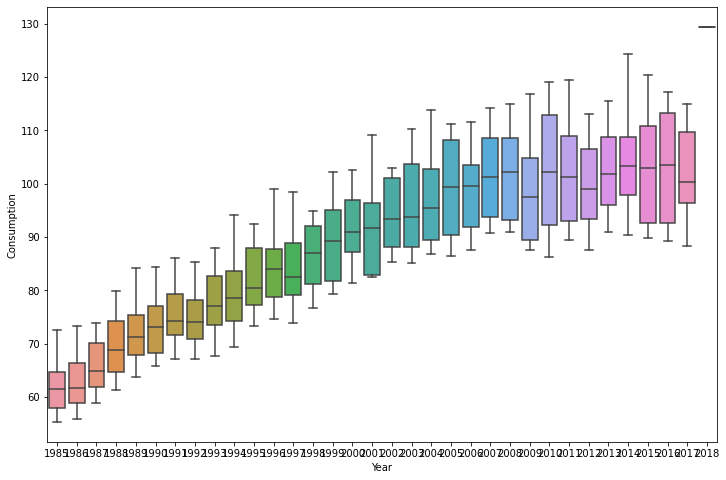

In [16]:
sns.boxplot(x="Year",y="Consumption",data=series)

**Every year the amount of comsumption increases**

**There is an upward trend**

<AxesSubplot:xlabel='Day_of_week', ylabel='Consumption'>

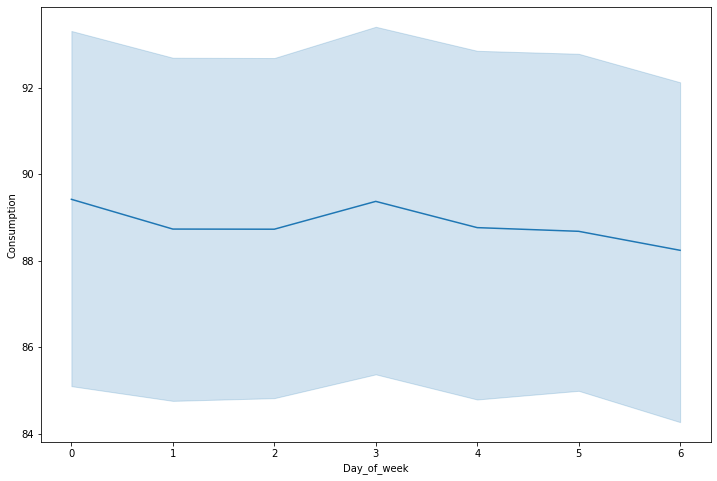

In [17]:
sns.lineplot(x="Day_of_week",y="Consumption",data=series)

<AxesSubplot:xlabel='Day_of_week', ylabel='Consumption'>

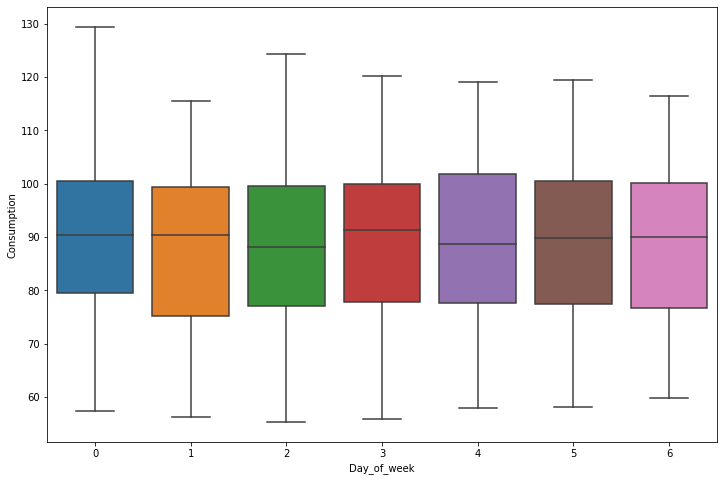

In [18]:
sns.boxplot(x="Day_of_week",y="Consumption",data=series)

**Consumption is nearly constant on all days of week**

**Function for checking the stationarity of Time Series**

In [19]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    sns.lineplot(y=series,x=series.index,)
    series.rolling(window=12).mean().plot()
    series.rolling(window=12).std().plot()
    result=adfuller(series,autolag="AIC")

    print(f"ADF Statistics: {result[0]}")
    print(f"p value: {result[1]}")

    for key,value in result[4].items():
        print(f"Critical Value {key}: {value}") 
        
    print("\n\n")

ADF Statistics: -2.2569903500472366
p value: 0.18621469116587053
Critical Value 1%: -3.4476305904172904
Critical Value 5%: -2.869155980820355
Critical Value 10%: -2.570827146203181





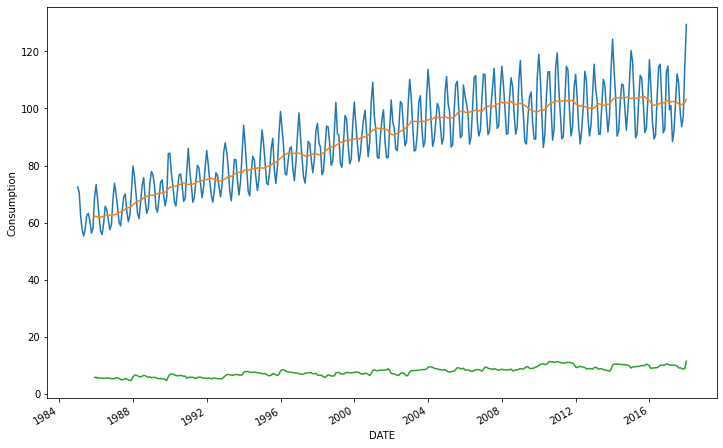

In [20]:
check_stationarity(series["Consumption"])

**For stationary series mean and standard deviation should be constant over time**

**As p value is more than 0.05 we cannot reject null hypothesis that series is non-statinary**

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

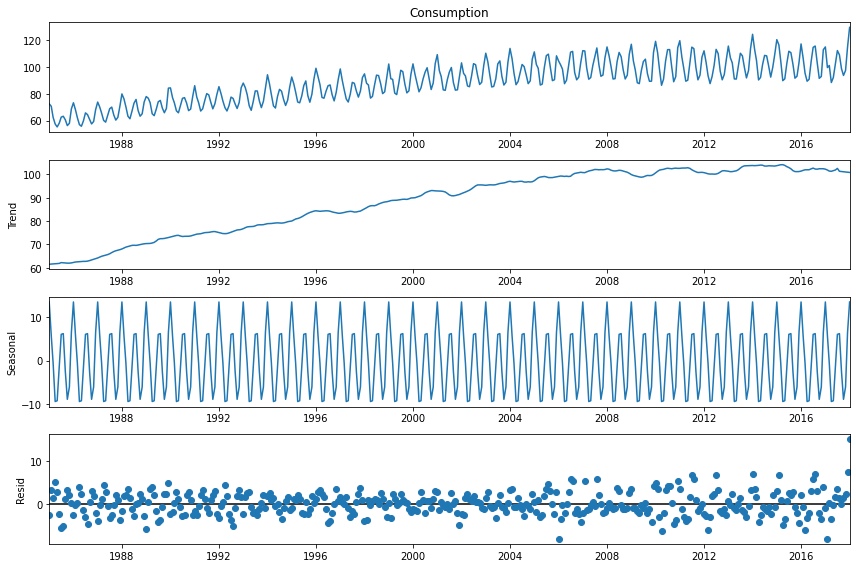

In [22]:
result_additive=seasonal_decompose(series["Consumption"],model="additive",extrapolate_trend="freq")
result_additive.plot();

**Autocorrelation and Partial-Autocorrelation plots**

In [23]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

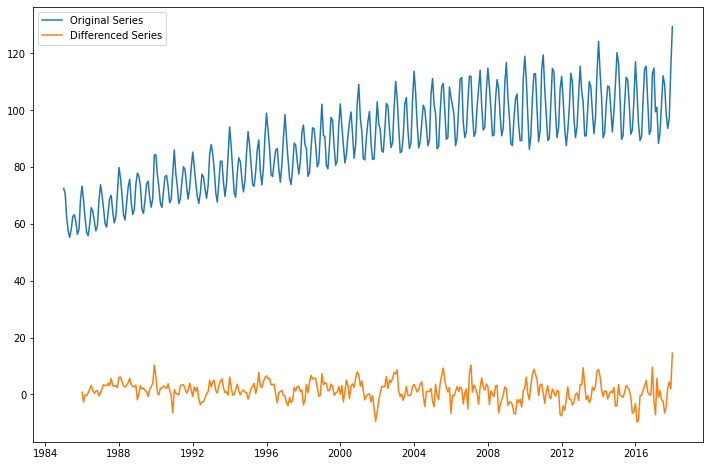

In [24]:
diff_12=series["Consumption"].diff(12).dropna()

plt.plot(series["Consumption"],label="Original Series")
plt.plot(diff_12,label="Differenced Series")
plt.legend(loc="upper left")

ADF Statistics: -5.67348202338176
p value: 8.812644938088942e-07
Critical Value 1%: -3.4480516066132636
Critical Value 5%: -2.869340997473759
Critical Value 10%: -2.5709257824604





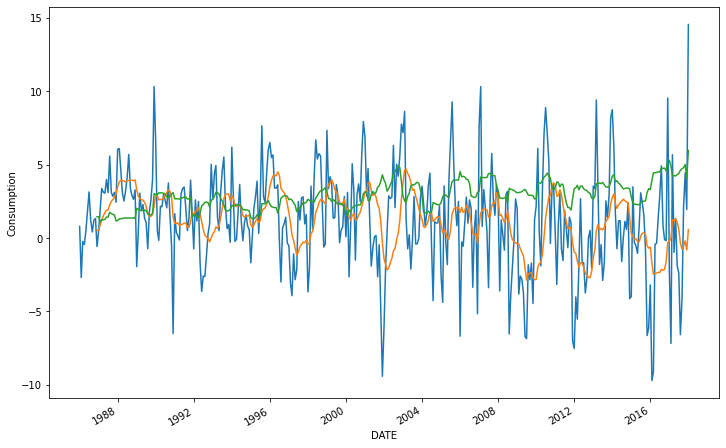

In [25]:
check_stationarity(diff_12)

**As p value is less than 0.05, the time series is stationary**

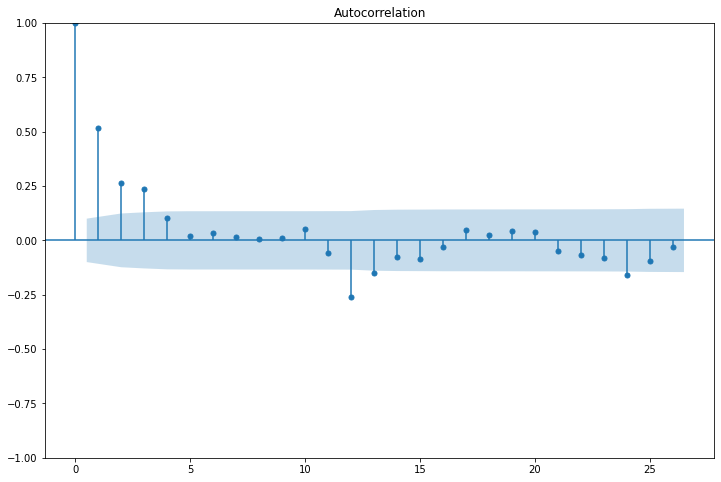

In [26]:
plot_acf(diff_12);

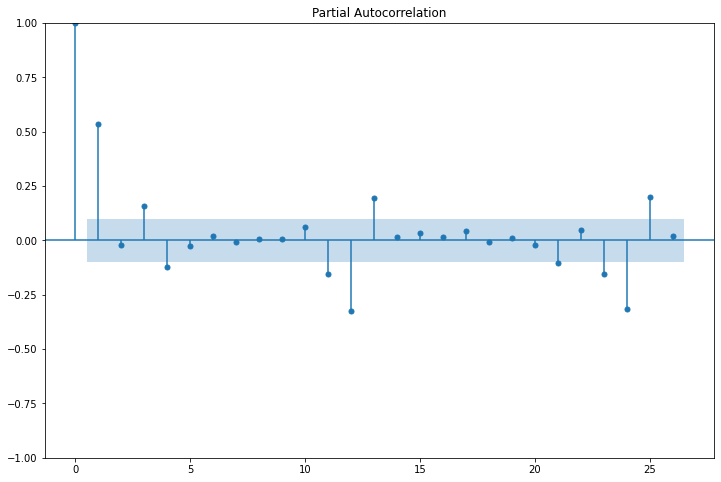

In [27]:
plot_pacf(diff_12,method="ols");

**Building the Sarima Model using Gridsearch**

In [28]:
p=range(0,4) 
d=range(0,2) 
q=range(0,4) 

In [29]:
import itertools

In [30]:
pdq=list(itertools.product(p,d,q))
PDQS=[(x[0],x[1],x[2],12) for x in pdq]

In [31]:
import statsmodels.api as sm

In [32]:
best=np.inf
b_order=()
bs_order=()

for param in pdq: 
    for seasonal_param in PDQS:
        model = sm.tsa.statespace.SARIMAX(series["Consumption"],
                                            order=param,
                                            seasonal_order=seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False,
                                            freq="MS") 
        results = model.fit(disp=False)
        
        if(results.aic<best):
            best=results.aic
            b_order=param
            bs_order=seasonal_param

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-

In [33]:
print(f"\n\nBest Model: order:{b_order} and seasonal order: {bs_order}")



Best Model: order:(2, 1, 3) and seasonal order: (0, 1, 3, 12)


In [34]:
model = sm.tsa.statespace.SARIMAX(series["Consumption"],
                                order=b_order,
                                seasonal_order=bs_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                freq="MS") 
results = model.fit(disp=-1)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [35]:
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-0.7103,0.114,-6.221,0.000,-0.934,-0.487
ar.L2,0.2549,0.113,2.251,0.024,0.033,0.477
ma.L1,0.3068,0.112,2.751,0.006,0.088,0.525
ma.L2,-0.8782,0.043,-20.541,0.000,-0.962,-0.794
ma.L3,-0.2767,0.096,-2.891,0.004,-0.464,-0.089
ma.S.L12,-0.8220,0.052,-15.945,0.000,-0.923,-0.721
ma.S.L24,-0.1856,0.063,-2.926,0.003,-0.310,-0.061
ma.S.L36,0.2688,0.057,4.708,0.000,0.157,0.381
sigma2,5.7544,0.375,15.349,0.000,5.020,6.489


**p>|z| column all values are less than 0.05 meaning they are highly significant**

**Coefficients are also significant**

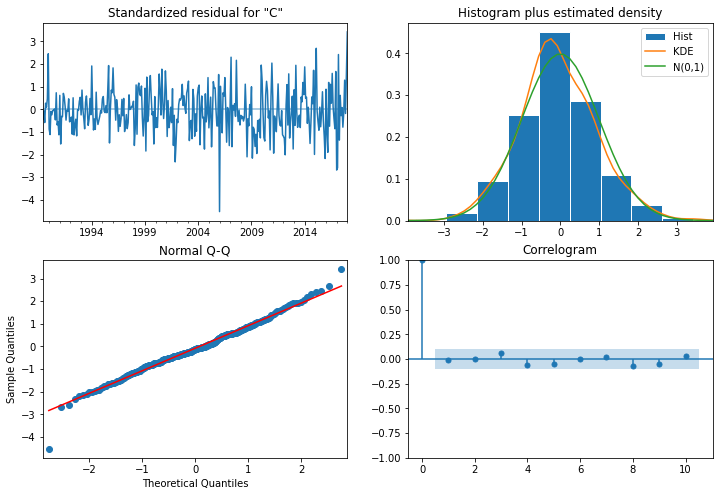

In [36]:
results.plot_diagnostics();

**Standardized residual plot:**
Residual mean is zero and uniform variance as kde plot has normal distribution



**Correlogram:**
All correlation are below significance level, hence residue error are not correlated and no pattern left unaccounted by model

In [37]:
n_periods=24

forecast = results.get_forecast(24).summary_frame()

In [38]:
forecast

Consumption,mean,mean_se,mean_ci_lower,mean_ci_upper
2018-02-01,114.975541,2.398829,110.273922,119.677161
2018-03-01,105.077512,2.793185,99.602971,110.552053
2018-04-01,91.077359,2.861862,85.468213,96.686505
2018-05-01,93.364662,2.876148,87.727514,99.001809
2018-06-01,103.321861,2.893861,97.649998,108.993725
2018-07-01,113.103543,2.901478,107.416750,118.790336
2018-08-01,110.825589,2.916583,105.109191,116.541987
2018-09-01,101.398645,2.923933,95.667842,107.129449
2018-10-01,93.103853,2.938536,87.344428,98.863279
2018-11-01,97.689055,2.945972,91.915056,103.463054


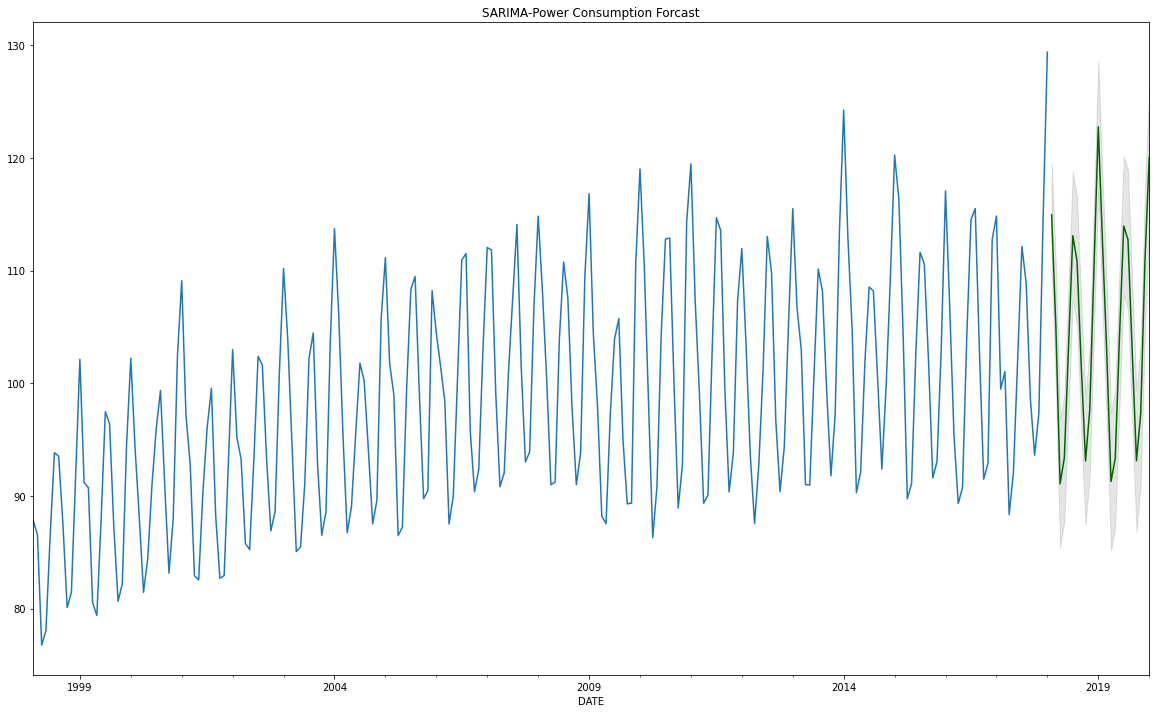

In [39]:
plt.title("SARIMA-Power Consumption Forcast")
series["Consumption"][-240:].plot(figsize=(20,12))
forecast["mean"].plot(color="darkgreen")
plt.fill_between(forecast.index, forecast['mean_ci_lower'], forecast['mean_ci_upper'], color='k', alpha=0.1)

**The same model can be implemented much more easily using the pmdarima module,below pmdarima is used to built the model**

**Sarima Model using pmdarima**

In [40]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 291 kB/s            
Note: you may need to restart the kernel to use updated packages.


In [41]:
import pmdarima as pm

In [42]:
model=pm.auto_arima( series["Consumption"],start_p=0,start_q=0,
              test='adf',
              d=None,                     #use adftest to find optimal 'd'        
              max_p=3,max_q=3,max_d=1,
              start_P=0,start_Q=0,
              D=1,                       # enforcing D=1
              max_P=3,max_Q=3,
              seasonal=True,
              m=12)                     # frequency of seasonality

In [43]:
print(model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  397
Model:             SARIMAX(3, 0, 3)x(2, 1, [1, 2], 12)   Log Likelihood                -876.504
Date:                                 Tue, 19 Apr 2022   AIC                           1775.007
Time:                                         09:28:07   BIC                           1818.493
Sample:                                              0   HQIC                          1792.254
                                                 - 397                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2862      0.108      2.646      0.008       0.074       0

**p>|z| column all values are less than 0.05 meaning they are highly significant**

**Coefficients are also significant**

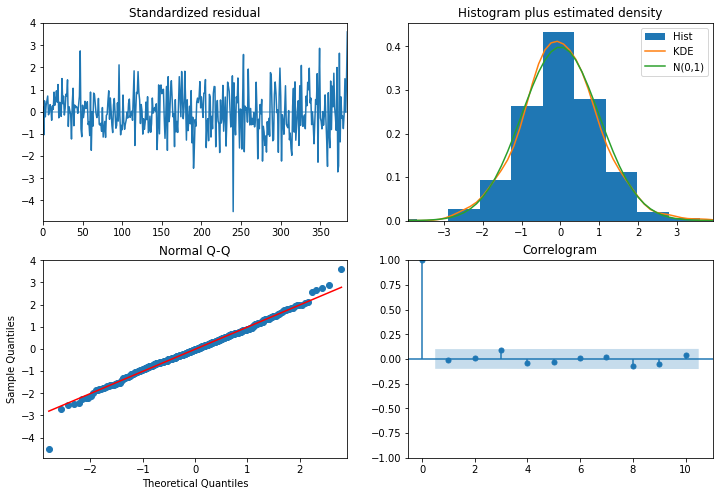

In [44]:
model.plot_diagnostics();

**Standardized residual plot:**
Residual mean is zero and uniform variance as kde plot has normal distribution



**Correlogram:**
All correlation are below significance level, hence residue error are not correlated and no pattern left unaccounted by model

**Forcasting for 2 year**

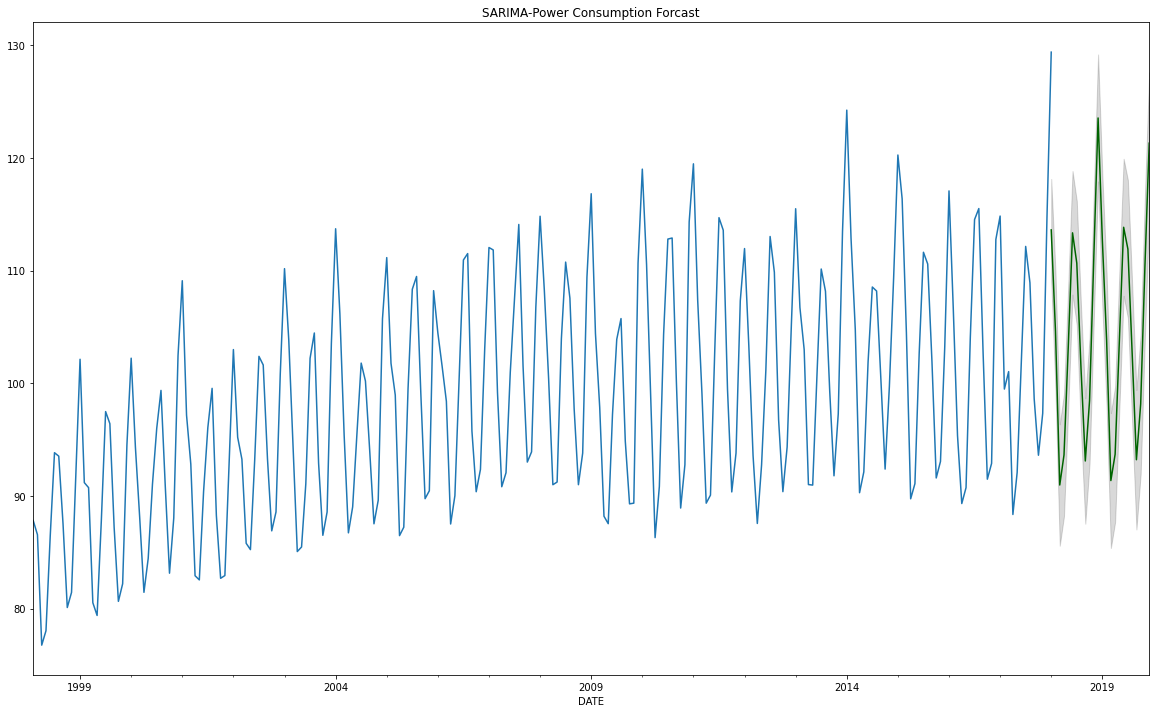

In [45]:
n_periods=24

forcast,conf_interval=model.predict(n_periods,return_conf_int=True)
forcast_index=pd.date_range(series.index[-1],periods=n_periods,freq="MS")

forcasted=pd.Series(forcast,index=forcast_index)
lower=pd.Series(conf_interval[:,0],index=forcast_index)
upper=pd.Series(conf_interval[:,1],index=forcast_index)

plt.title("SARIMA-Power Consumption Forcast")
series["Consumption"][-240:].plot(figsize=(20,12))
forcasted.plot(color="darkgreen")
plt.fill_between(lower.index,lower,upper,color="k",alpha=0.15)

**Useful Resources for theoretical understanding**

https://www.kaggle.com/learn/time-series/discussion/303422#1666153